## Optimization Project - 2

* Nittala Venkata Sai Aditya - vn5227
* Rukh Agha - msa3453
* Rajshree Mishra - rm62528
* Aakash Talathi - art2963


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import binom
import warnings
warnings.filterwarnings('ignore')

# Assumptions

To evaluate overbooking, we will run simulations incorporating an overbooking strategy and analyze the results. For simulations, the assumptions are as follow:

* The plane has two cabins: coach and first-class.
* Each day up to one reservation can be sold in each class.
* There are 365 days to sell reservations for a flight.
* Coach reservations can be sold each day at a price of \\$300 with a probability of 65% or at a price of \\$350 with a probability of 30%.
* First-class reservations can be sold each day at a price of \\$425 with a probability of 8% or at a price of \\$500 with a probability of 4%.
* There are 100 seats in coach and 20 seats in first class. For overbooking simulations, reservations sold for a cabin can exceed seats in a cabin.
* On the day of the flight, the chance of a no-show in coach is 5% and the chance of a no-show in first-class is 3%.
* The cost to upgrade a coach passenger to first-class is \\$50
* The cost to voucher a passenger and remove them from the flight is \\$425.
* The annual discount rate is 17%.


## Initialising variables

In [2]:
price_ranges = {
    'coach': {
        'low': 300,
        'high': 350
    },
    'first': {
        'low': 425,
        'high': 500
    }
}

# Set demand probabilities
demand_probs = {
    'coach': {
        'low': [0.65,0.35], # [No Sale, Sale]
        'low_soldout' : [0.68,0.32],
        'high': [ 0.3,0.7], # [No Sale, Sale]
        'high_soldout':[0.33,0.67]
        
    },
    'first': {
        'low': [0.08,0.92], # [No Sale, Sale]
        'high': [ 0.04,0.96] # [No Sale, Sale]
    }
}

# Set discount rate (Discount rate - 17%)
discount = 1 / (1 + (0.17 / 365))

# Set number of seats
num_seats = {
    'coach': 100,
    'first': 20
}

# Set number of days until takeoff
num_days = 365

# Set parameters for overbooking
allow_extra = 5
pshow = {
    'coach': 0.95,
    'first': 0.97
}

first_bump_cost = -50    # cost if coach passenger is bumped to first class
plane_bump_cost = -425   # cost if the overbooked passenger is bumped of the plane



# Methodology
In general, we evaluated the total net revenues from simulations that used dynamic programming to determine the best price to charge each day based on conditions (or state variables) and updated conditions based on random demand variables. In order to evaluate overbooking strategies, we adjusted the maximum available coach reservations that can be sold to exceed the seats in the coach cabin. Information for the simulation is as follows:

State variables:
t: days that have passed
c: coach reservations remaining
f: first-class reservations remaining

The initial state without overbooking would be (0, 100, 20) and the initial state for allowing z overbooked reservations would be (0, 100+z, 20).

Decision variables:
* hc : high price of coach reservations; \\$350
* lc : low price of coach reservations; \\$300
* hf : high price of coach reservations; \\$500


lf : low price of coach reservations; \\$425
<br>The decision variables are subject to the following conditions: 
<br>hc + lc = 1 (one and only one price must be chosen for the coach class cabin each day)
<br>hf + lf = 1 (one and only one price must be chosen for the first class cabin each day)

<br>Dynamics:
<br>t 		→ t + 1
<br>c | hc = 1	→ c - 1, w.p. 0.3
		→ c, w.p. 0.7
<br>c | lc = 1	→ c - 1, w.p. 0.65
		→ c, w.p. 0.35
<br>f | hf = 1	→ f - 1, w.p. 0.04
		→ f, w.p. 0.96
<br>f | lf = 1		→ f - 1, w.p. 0.08
		→ f, w.p. 0.92

Bellman equation:
d = 0.83 = (1 - discount rate)
<br>V(t, c, f) = max [

**(0.35*0 + 0.65*300) + (0.92*0 + 0.08*425) + d*(0.35*0.92*V(t + 1, c, f)  + 0.65*0.92*V(t + 1, c - 1, f)  + 0.35*0.08*V(t + 1, c, f - 1)  + 0.65*0.08*V(t + 1, c - 1 , f - 1)) ,
<br>^ if lc and lf
(0.70*0 + 0.30*350) + (0.92*0 + 0.08*425) + d*(0.70*0.92*V(t + 1, c, f)  + 0.30*0.92*V(t + 1, c - 1, f)  + 0.70*0.08*V(t + 1, c, f - 1)  + 0.30*0.08*V(t + 1, c - 1 , f - 1)) ,
<br>^ if hc and lf
(0.35*0 + 0.65*300) + (0.96*0 + 0.04*500) + d*(0.35*0.96*V(t + 1, c, f)  + 0.65*0.96*V(t + 1, c - 1, f)  + 0.35*0.04*V(t + 1, c, f - 1)  + 0.65*0.04*V(t + 1, c - 1 , f - 1)) ,
<br>^ if lc and hf
(0.70*0 + 0.30*350) + (0.96*0 + 0.04*500) + d*(0.70*0.96*V(t + 1, c, f)  + 0.30*0.96*V(t + 1, c - 1, f)  + 0.70*0.04*V(t + 1, c, f - 1)  + 0.30*0.04*V(t + 1, c - 1 , f - 1))
<br>^ if hc and hf

]
** Using an if statement: if f = 0, then repeat the above Bellman equation with the following changes:
<br>0.35 → 0.32
<br>0.65 → 0.68
<br>0.3 → 0.33
<br>0.7 → 0.67

Terminal conditions:
<br>V(T, c, f) = 0
<br>V(t, 0, 0) = 0



In [3]:
def overbooking_DP(no_selling,overbook):    
    seat_left_coach = np.arange(num_seats['coach']+overbook+1)  # all possible number of coach seats left
    seat_left_first = np.arange(num_seats['first']+1)  # all possible number first class  of seats left
    tdays = np.arange(num_days+1)                 # all possible days until takeoff
    num_coach=len(seat_left_coach)  # number of coach seats
    num_first=len(seat_left_first)  # number of first class seats
    tN=len(tdays)
  
    V = np.zeros((num_coach,num_first,tN))   # initialize value function
    U = np.zeros((num_coach,num_first,tN)) # initialize optimal choice variable
    
    # boundary/terminal condition
    U[:,:,tN-1] = 0  # 0 is the value for no tickets for sale
    
    # filling the all possible values of coach and first class seats with expected cost at time tN( at time of departure)
    for coach_sold in range(num_coach):
        for first_sold in range(num_first): 
            revenue = 0 
            for i in range(coach_sold+1): 
                for j in range(first_sold+1):
                    if i > num_seats['coach']:
                        prob = binom.pmf(i, coach_sold, pshow['coach']) * binom.pmf(j, first_sold, pshow['first'])
                        num_plane_bump = max(i-num_seats['coach'],0) 
                        num_first_bump= min(num_seats['first']-j,num_plane_bump)
                        temp = (first_bump_cost*num_first_bump + (num_plane_bump-num_first_bump)*plane_bump_cost)
                        revenue += temp*prob

            V[coach_sold, first_sold , tN-1] = revenue
            
            
            
    for t in reversed(range(tN-1)): 
        for i in range(num_coach):  
            for j in range(num_first): 

                # all are sold out
                if (i == num_coach-1) and (j == num_first-1):
                    V[i, j, t] = discount * V[i, j, t+1]
                    U[i, j, t] = 0 

                    #coach is sold out and first class is available
                elif (i == num_coach-1) and (j < num_first-1): 
                    V_CH_FH = price_ranges['first']['high'] * demand_probs['first']['high'][0] + discount*(demand_probs['first']['high'][0]*V[i, j+1, t+1] + demand_probs['first']['high'][1]*V[i, j, t+1])
                    V_CH_FL = price_ranges['first']['low'] * demand_probs['first']['low'][0] + discount*(demand_probs['first']['low'][0]*V[i, j+1, t+1] + demand_probs['first']['low'][1]*V[i, j, t+1])
                    V_CL_FH = V_CH_FH
                    V_CL_FL = V_CH_FL
                    V[i, j, t] = max(V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL)
                    U[i, j, t] = np.argmax([V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL])+1 
                    
                    #first class is sold out and coach class is available

                elif (i < num_coach-1) and (j == num_first-1): 
                    V_CH_FH = price_ranges['coach']['high'] * demand_probs['coach']['high_soldout'][0] + discount*(demand_probs['coach']['high_soldout'][0]*V[i+1, j, t+1] + demand_probs['coach']['high_soldout'][1]*V[i, j, t+1])
                    V_CL_FH = price_ranges['coach']['low'] * demand_probs['coach']['low_soldout'][0] + discount*(demand_probs['coach']['low_soldout'][0]*V[i+1, j, t+1] + demand_probs['coach']['low_soldout'][1]*V[i, j, t+1])
                    V_CH_FL = V_CH_FH
                    V_CL_FL = V_CL_FH
                    
                    if no_selling:
                        V_N_FH = discount*(demand_probs['coach']['high_soldout'][0] * V[i, j, t+1] + demand_probs['coach']['high_soldout'][1] * V[i, j, t+1])
                        V_N_FL = discount*(demand_probs['coach']['low_soldout'][0] * V[i, j, t+1] + demand_probs['coach']['low_soldout'][1] * V[i, j, t+1])        
                        V[i, j, t] = max(V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL, V_N_FH , V_N_FL)
                        U[i, j, t] = np.argmax([V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL, V_N_FH , V_N_FL])+1 
                    else:
                        V[i, j, t] = max(V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL)
                        U[i, j, t] = np.argmax([V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL])+1 
                        

                    
                    # coach and first class seats  are available
                else: 
                    V_CH_FH = (price_ranges['coach']['high'] + price_ranges['first']['high']) * demand_probs['first']['high'][0] * demand_probs['coach']['high'][0] + \
                    price_ranges['coach']['high'] * demand_probs['coach']['high'][0] * demand_probs['first']['high'][1] + price_ranges['first']['high'] * demand_probs['first']['high'][0] * demand_probs['coach']['high'][1] + \
                    discount*(demand_probs['coach']['high'][0] * demand_probs['first']['high'][0] * V[i+1, j+1, t+1] + demand_probs['coach']['high'][0] * demand_probs['first']['high'][1]*V[i+1, j, t+1] + \
                              demand_probs['coach']['high'][1] * demand_probs['first']['high'][0]*V[i, j+1, t+1] + demand_probs['coach']['high'][1] * demand_probs['first']['high'][1]*V[i, j, t+1])


                    V_CH_FL =  (price_ranges['coach']['high'] + price_ranges['first']['low']) * demand_probs['coach']['high'][0] * demand_probs['first']['low'][0] + price_ranges['coach']['high'] * demand_probs['coach']['high'][0] * demand_probs['first']['low'][1] + \
                    price_ranges['first']['low'] * demand_probs['first']['low'][0] * demand_probs['coach']['high'][1] + discount*(demand_probs['coach']['high'][0] * demand_probs['first']['low'][0] * V[i+1, j+1, t+1] + \
                              demand_probs['coach']['high'][0] * demand_probs['first']['low'][1]*V[i+1, j, t+1] + demand_probs['coach']['high'][1] * demand_probs['first']['low'][0]*V[i, j+1, t+1] + \
                              demand_probs['coach']['high'][1] * demand_probs['first']['low'][1]*V[i, j, t+1])


                    V_CL_FH =  (price_ranges['coach']['low'] + price_ranges['first']['high']) * demand_probs['coach']['low'][0] * demand_probs['first']['high'][0] + \
                    price_ranges['coach']['low'] *  demand_probs['coach']['low'][0] * demand_probs['first']['high'][1] + price_ranges['first']['high'] * demand_probs['first']['high'][0] * demand_probs['coach']['low'][1] + \
                    discount*(demand_probs['coach']['low'][0] * demand_probs['first']['high'][0] * V[i+1, j+1, t+1] + demand_probs['coach']['low'][0] * demand_probs['first']['high'][1]*V[i+1, j, t+1] + \
                              demand_probs['coach']['low'][1] * demand_probs['first']['high'][0]*V[i, j+1, t+1] + demand_probs['coach']['low'][1] * demand_probs['first']['high'][1]*V[i, j, t+1])


                    V_CL_FL =  (price_ranges['coach']['low'] + price_ranges['first']['low']) * demand_probs['coach']['low'][0] * demand_probs['first']['low'][0] + \
                    price_ranges['coach']['low']  * demand_probs['coach']['low'][0] * demand_probs['first']['low'][1] +  price_ranges['first']['low'] * demand_probs['first']['low'][0] * demand_probs['coach']['low'][1] + \
                    discount*(demand_probs['coach']['low'][0] * demand_probs['first']['low'][0] * V[i+1, j+1, t+1] +  demand_probs['coach']['low'][0] * demand_probs['first']['low'][1]*V[i+1, j, t+1] + \
                              demand_probs['coach']['low'][1] * demand_probs['first']['low'][0]*V[i, j+1, t+1] + demand_probs['coach']['low'][1] * demand_probs['first']['low'][1]*V[i, j, t+1])

                    # IF NO SALE IS AN OPTION
                    if no_selling:
                        V_N_FH = price_ranges['first']['high'] * demand_probs['first']['high'][0] + discount*(demand_probs['first']['high'][0] * V[i, j+1, t+1] + demand_probs['first']['high'][1]*V[i, j, t+1])
                        V_N_FL = price_ranges['first']['low'] * demand_probs['first']['low'][0] + discount*(demand_probs['first']['low'][0] * V[i, j+1, t+1] + demand_probs['first']['low'][1]*V[i, j, t+1])

                        V[i, j, t] = max(V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL, V_N_FH, V_N_FL)
                        U[i, j, t] = np.argmax([V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL, V_N_FH, V_N_FL])+1 
                    else: 
                        V[i, j, t] = max(V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL)
                        U[i, j, t] = np.argmax([V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL])+1 

                    
    return V, U

    

### Question - 1

In [4]:
V, U = overbooking_DP(False,allow_extra)

#Overbooking=5
print('Expected profit = ${} when overbooking is {}'.format(V[0,0,0],allow_extra))

Expected profit = $41886.158624195894 when overbooking is 5


### Question - 2

In [5]:
overbooking_array = np.arange(5,16)
expected_profit = []
for i in overbooking_array:
    V, U = overbooking_DP(False,i)
    expected_profit.append(V[0,0,0])
    print('Expected profit = ${} when overbooking is {}'.format(V[0,0,0],i))

Expected profit = $41886.158624195894 when overbooking is 5
Expected profit = $42011.221060444565 when overbooking is 6
Expected profit = $42085.536155828806 when overbooking is 7
Expected profit = $42122.167268763085 when overbooking is 8
Expected profit = $42134.624830341694 when overbooking is 9
Expected profit = $42132.90038235115 when overbooking is 10
Expected profit = $42123.66593558076 when overbooking is 11
Expected profit = $42111.02967047866 when overbooking is 12
Expected profit = $42097.41950987739 when overbooking is 13
Expected profit = $42084.1115703531 when overbooking is 14
Expected profit = $42071.74230930798 when overbooking is 15


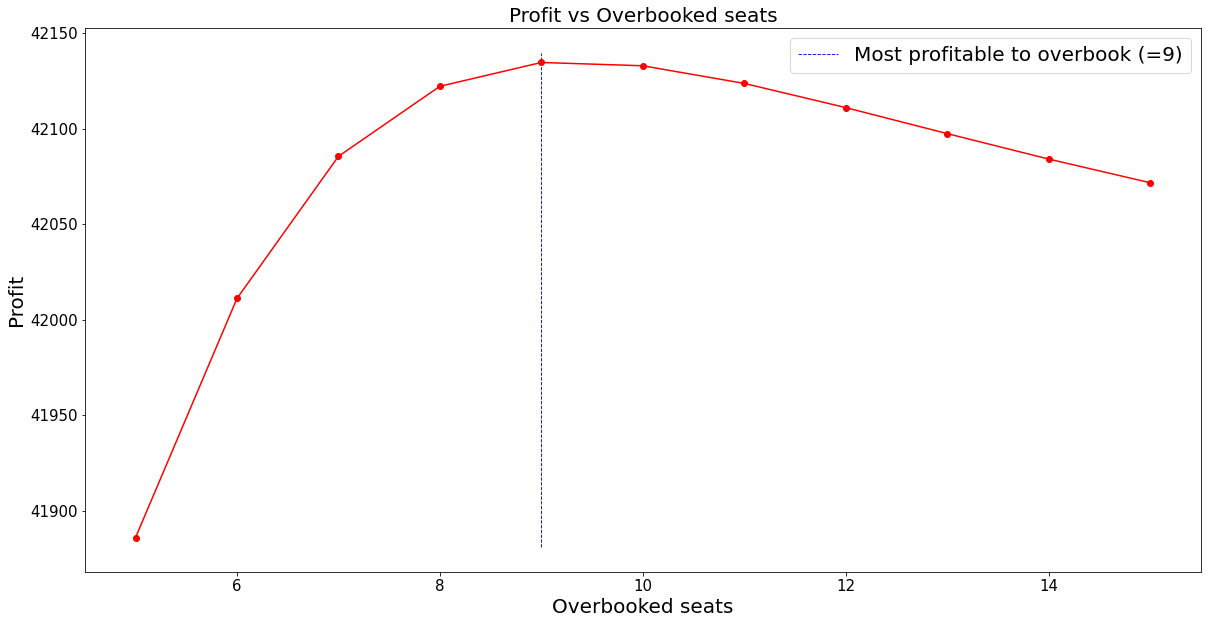

In [6]:
plt.figure(figsize=(20,10))
plt.plot(overbooking_array, expected_profit,color='r',marker='o')
plt.vlines(np.argmax(expected_profit) + 5, np.min(expected_profit)-5, np.max(expected_profit)+ 5, colors='b', linestyles='dashed', linewidth= 0.9, label=f'Most profitable to overbook (={np.argmax(expected_profit) + 5})')
plt.xlabel('Overbooked seats',fontsize=20)
plt.ylabel('Profit',fontsize=20)
plt.title('Profit vs Overbooked seats',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)
plt.show()

The highest expected profit is when number of over bookings is at 9 and profit is $ 42134.62

### Q3

In [8]:
expected_profit_second = []
for i in np.arange(5,20):
    V, U = overbooking_DP(True,i)
    expected_profit_second.append(V[0,0,0])
    print('Expected profit = ${} when overbooking is {}'.format(V[0,0,0],i))

Expected profit = $41886.158624195894 when overbooking is 5
Expected profit = $42011.221060444565 when overbooking is 6
Expected profit = $42085.536155828806 when overbooking is 7
Expected profit = $42122.167268763085 when overbooking is 8
Expected profit = $42134.624830341694 when overbooking is 9
Expected profit = $42138.14049791317 when overbooking is 10
Expected profit = $42139.32793981838 when overbooking is 11
Expected profit = $42139.708945066326 when overbooking is 12
Expected profit = $42139.83142494605 when overbooking is 13
Expected profit = $42139.872224934035 when overbooking is 14
Expected profit = $42139.88608106459 when overbooking is 15
Expected profit = $42139.89071111938 when overbooking is 16
Expected profit = $42139.89218324264 when overbooking is 17
Expected profit = $42139.89261726656 when overbooking is 18
Expected profit = $42139.8927340246 when overbooking is 19


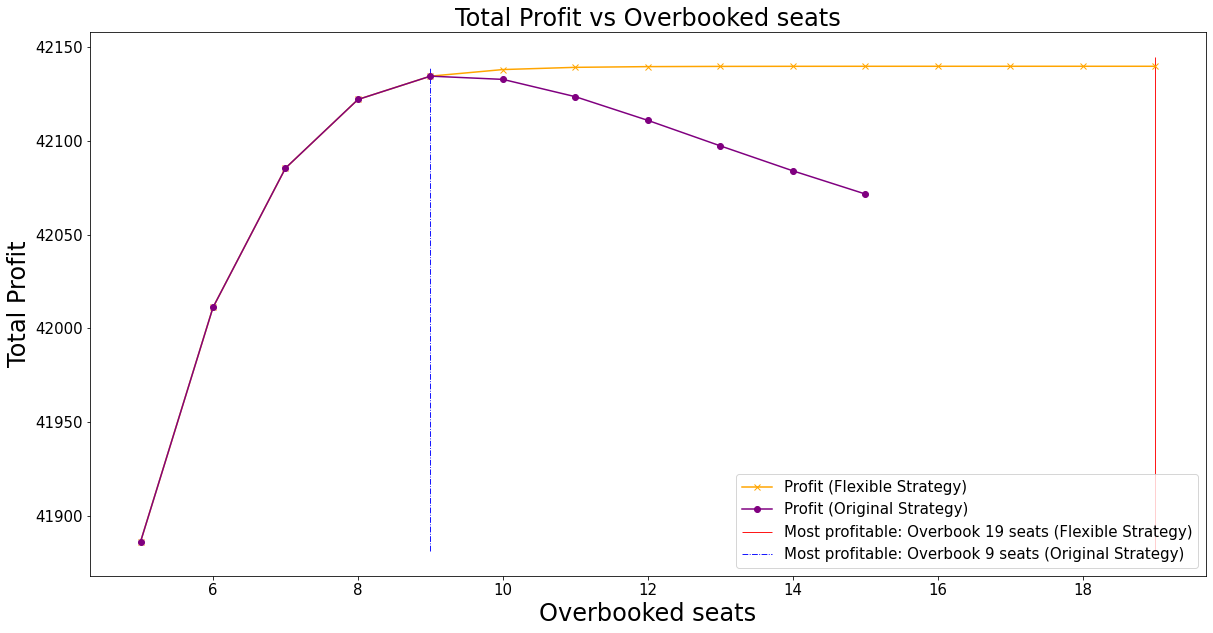

In [9]:
plt.figure(figsize=(20,10))

plt.plot(list(range(5,20)), expected_profit_second, label='Profit (Flexible Strategy)', color='orange',marker='x')
plt.vlines(np.argmax(expected_profit_second) + 5, np.min(expected_profit_second)-5, np.max(expected_profit_second)+ 5, colors='r', linestyles='solid', linewidth= 0.9, label=f'Most profitable: Overbook {np.argmax(expected_profit_second) + 5} seats (Flexible Strategy)')

plt.plot(overbooking_array, expected_profit, label='Profit (Original Strategy)', color='purple',marker='o')
plt.vlines(np.argmax(expected_profit) + 5, np.min(expected_profit)-5, np.max(expected_profit)+ 5, colors='blue', linestyles='dashdot', linewidth= 0.9, label=f'Most profitable: Overbook {np.argmax(expected_profit) + 5} seats (Original Strategy)')
plt.xlabel('Overbooked seats',fontsize=24)
plt.ylabel('Total Profit',fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Total Profit vs Overbooked seats',fontsize=24)
plt.legend(fontsize=15)
plt.show()

<b> We see that the profit keeps on increasing so we check the profit at overbooking=20 <b>

In [10]:
V, U = overbooking_DP(True,20)
print('Expected profit = ${} when overbooking is 20'.format(V[0,0,0]))

Expected profit = $42139.8927623198 when overbooking is 20


The latter strategy seems to perform better. The expected profit with no sale option and 20 over booking is more than the expected profit with 9 overbookings.

### Q4

In [11]:
def overbooking_simulation(U, overbook):
  
    seat_left_coach = np.arange(num_seats['coach']+overbook+1) # all possible number of coach seats left
    seat_left_first = np.arange(num_seats['first']+1)  # all possible number of first class seats left
    tdays = np.arange(num_days+1)  # all possible days until take off
    num_coach=len(seat_left_coach) 
    num_first=len(seat_left_first) 
    tN=len(tdays)
    revenue,c,f=[0,0,0]
    

    for t in range(tN-1):
        # getting the optimum price decision at time t
        price_opt = U[c, f, t] 
        
        coach_prob,coach_price,first_prob,first_price=[0,0,0,0]
        
        # setting coach and first prices based on the optimum price decision
        if (price_opt==1) |(price_opt==2):
            coach_prob = demand_probs['coach']['high'][0]
            coach_price = price_ranges['coach']['high']

        if (price_opt==3) |(price_opt==4):
            coach_prob = demand_probs['coach']['low'][0]
            coach_price = price_ranges['coach']['low']

        if (price_opt==1) |(price_opt==3):
            first_prob = demand_probs['first']['high'][0]
            first_price = price_ranges['first']['high']

        if (price_opt==4) |(price_opt==2):
            first_prob = demand_probs['first']['low'][0]
            first_price = price_ranges['first']['low']

        if price_opt == 5: 
            first_prob = demand_probs['first']['high'][1]
            first_price = price_ranges['first']['high']

        if price_opt == 6:
            coach_prob = demand_probs['first']['low'][1]
            first_prob = price_ranges['first']['low']


        if c == num_coach - 1:
            coach_prob = 0
        if f == num_first - 1:
            first_prob = 0

        coach_sale = (np.random.random(1) < coach_prob) 
        first_sale = (np.random.random(1) < first_prob) 
        revenue += (coach_sale*coach_price + first_sale*first_price) * discount**t
        c += coach_sale
        f += first_sale
        

     # number of people showed up
    coach_showup = np.random.binomial(c, pshow['coach'])
    first_showup = np.random.binomial(f, pshow['first'])
    
    oversold = max(coach_showup-num_seats['coach'],0)
    first_bump = min(num_seats['first']-first_showup,oversold)

    profit = revenue
    num_overbook = max(0, c - num_seats['coach'])
    cost_overbook = (first_bump_cost*first_bump + (oversold-first_bump)*plane_bump_cost)
    bump_out_plane = max(oversold-first_bump, 0)

    return profit, num_overbook, cost_overbook, bump_out_plane

    


In [12]:
nsim = 1000
profit_fpolicy = np.zeros(nsim) 
num_overbook_fpolicy = np.zeros(nsim) 
cost_overbook_fpolicy = np.zeros(nsim) 
bump_out_plane_fpolicy = np.zeros(nsim)
profit_spolicy = np.zeros(nsim) 
num_overbook_spolicy = np.zeros(nsim) 
cost_overbook_spolicy = np.zeros(nsim) 
bump_out_plane_spolicy = np.zeros(nsim)

# # getting optimal value fucntion and decision at the best value of 9 over bookings and No sale option with 20 overbookings
V, U_fpolicy = overbooking_DP(False,9)
V, U_spolicy = overbooking_DP(True,20)

for i in range(nsim):
    profit_fpolicy[i], num_overbook_fpolicy[i], cost_overbook_fpolicy[i], bump_out_plane_fpolicy[i] = overbooking_simulation(U_fpolicy,9)
    profit_spolicy[i], num_overbook_spolicy[i], cost_overbook_spolicy[i], bump_out_plane_spolicy[i] = overbooking_simulation(U_spolicy,20)

In [13]:
## over booking

print("The percentage of overbooking in the first policy is  " ,(num_overbook_fpolicy > 0).sum()/len(num_overbook_fpolicy) * 100,' %')
## over booking

print("The percentage of overbooking in the second policy is  " ,(num_overbook_spolicy > 0).sum()/len(num_overbook_spolicy) * 100,' %')

The percentage of overbooking in the first policy is   100.0  %
The percentage of overbooking in the second policy is   100.0  %


In both the policies, the passengers are overbooked in each time

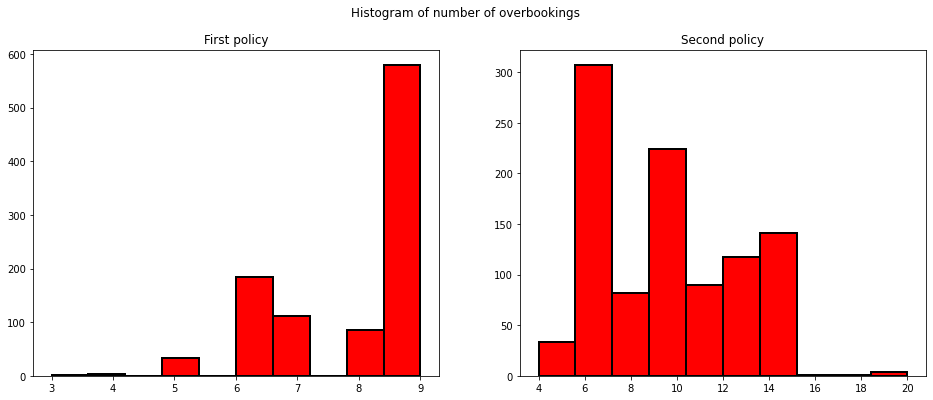

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
fig.suptitle('Histogram of number of overbookings')
ax1.hist(num_overbook_fpolicy,color='red',edgecolor='black',linewidth=2)
ax1.set_title('First policy')
ax2.hist(num_overbook_spolicy,color='red',edgecolor='black',linewidth=2)
ax2.set_title('Second policy')
fig.show()

In [15]:
## bumped off yhe plane
print("The percentage of times passengers kicked off the plane in the first policy is  " ,(bump_out_plane_fpolicy > 0).sum()/len(bump_out_plane_fpolicy) * 100,' %')
print("The percentage of times passengers kicked off the plane in the second policy is  " ,(bump_out_plane_spolicy > 0).sum()/len(bump_out_plane_spolicy) * 100,' %')

The percentage of times passengers kicked off the plane in the first policy is   67.30000000000001  %
The percentage of times passengers kicked off the plane in the second policy is   77.3  %


Passengers are kicked off the plane less often in the first policy

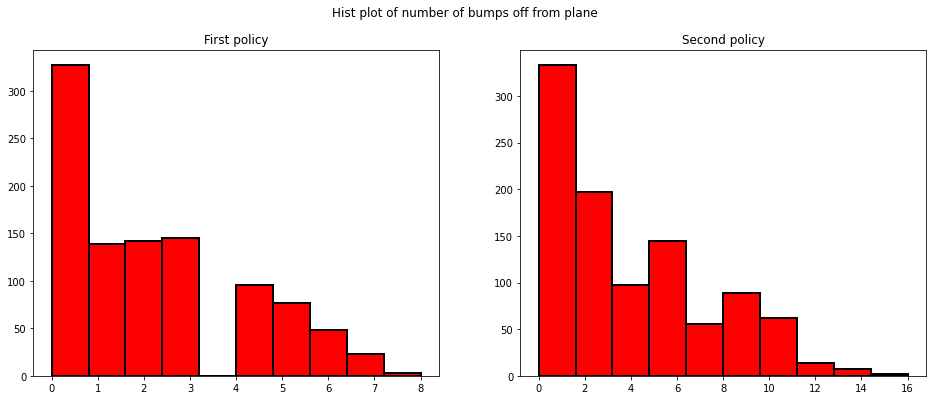

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
fig.suptitle('Hist plot of number of bumps off from plane')
ax1.hist(bump_out_plane_fpolicy,color='red',edgecolor='black',linewidth=2)
ax1.set_title('First policy')
ax2.hist(bump_out_plane_spolicy,color='red',edgecolor='black',linewidth=2)
ax2.set_title('Second policy')
fig.show()

In [17]:
##avg_overbooking_cost
avg_overbooking_cost_fpolicy = (profit_fpolicy + cost_overbook_fpolicy).mean()
avg_overbooking_cost_spolicy = (profit_spolicy + cost_overbook_spolicy).mean()
print('Average over booking cost of first policy is  $',avg_overbooking_cost_fpolicy )
print('Average over booking cost of second policy is  $',avg_overbooking_cost_spolicy )

Average over booking cost of first policy is  $ 41963.049689521744
Average over booking cost of second policy is  $ 41337.65432610932


 Average over booking cost is less in the second policy

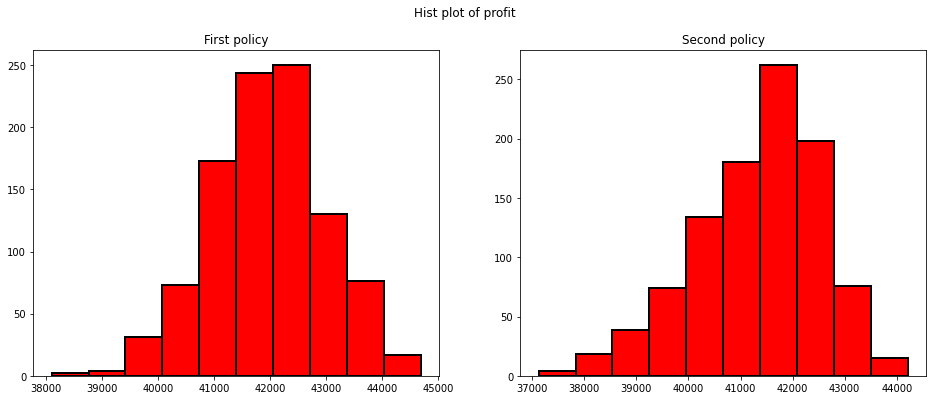

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
fig.suptitle('Hist plot of profit')
ax1.hist(profit_fpolicy + cost_overbook_fpolicy,color='red',edgecolor='black',linewidth=2)
ax1.set_title('First policy')
ax2.hist(profit_spolicy + cost_overbook_spolicy,color='red',edgecolor='black',linewidth=2)
ax2.set_title('Second policy')
fig.show()

In [19]:
##volatility
volatility_fpolicy = (profit_fpolicy +  cost_overbook_fpolicy).std()
volatility_spolicy = (profit_spolicy + cost_overbook_spolicy ).std()
print('volatility of first policy is  $',volatility_fpolicy )
print('volatility of second policy is  $',volatility_spolicy )

volatility of first policy is  $ 1012.7838544442294
volatility of second policy is  $ 1196.8930085287377


volatility is higher in the second policy

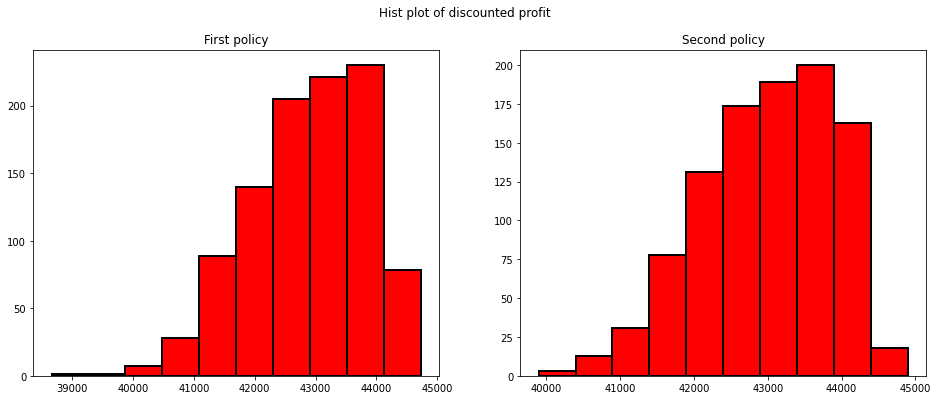

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
fig.suptitle('Hist plot of discounted profit')
ax1.hist(profit_fpolicy,color='red',edgecolor='black',linewidth=2)
ax1.set_title('First policy')
ax2.hist(profit_spolicy,color='red',edgecolor='black',linewidth=2)
ax2.set_title('Second policy')
fig.show()